# Import Libraries and Setup


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\queri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\queri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data Preprocessing
Clean tweets by removing URLs, mentions, special characters, and stopwords. Implement tokenization, stemming/lemmatization, and handle emojis.

In [ ]:
# Data Preprocessing

import re  # For regular expressions
from nltk.corpus import stopwords  # For stopwords
from nltk.stem import PorterStemmer  # For stemming
from nltk.stem import WordNetLemmatizer  # For lemmatization
%pip install emoji
import emoji  

nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_tweet(tweet):
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'\W', ' ', tweet)
    tweet = re.sub(r'\d', '', tweet)
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    tokens = tweet.split()
    tokens = [lemmatizer.lemmatize(stemmer.stem(word)) for word in tokens if word.lower() not in stop_words]
    tweet = ' '.join(tokens)
    return tweet

df = pd.read_csv('sentiment140.csv', encoding='ISO-8859-1')
print("Columns in the dataset:", df.columns.tolist())

df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']

df['cleaned_text'] = df['text'].apply(clean_tweet)

df[['text', 'cleaned_text']].head()

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\queri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\queri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Columns in the dataset: ['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY', '_TheSpecialOne_', "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"]


,text,cleaned_text
0,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
1,@Kenichan I dived many times for the ball. Man...,dive mani time ball manag save rest go bound
2,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
3,"@nationwideclass no, it's not behaving at all....",behav mad see
4,@Kwesidei not the whole crew,whole crew


# Feature Engineering
Convert text to numerical features using techniques like TF-IDF, Count Vectorization, or word embeddings. Extract additional features like tweet length, hashtag count, etc.

In [ ]:

tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])

count_vectorizer = CountVectorizer(max_features=10000)
X_count = count_vectorizer.fit_transform(df['cleaned_text'])

df['hashtag_count'] = df['text'].apply(lambda x: len([word for word in x.split() if word.startswith('#')]))
df['mention_count'] = df['text'].apply(lambda x: len([word for word in x.split() if word.startswith('@')]))
df['tweet_length'] = df['text'].apply(len)

from scipy.sparse import hstack

X_additional_features = df[['tweet_length', 'hashtag_count', 'mention_count']].values
X_combined = hstack([X_tfidf, X_additional_features])

X_combined.shape

(1599999, 10003)

# Building the Baseline Model
Implement and train simple classification models (Naive Bayes, Logistic Regression) as baseline. Create train/validation/test splits and establish performance benchmarks.

In [ ]:
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression

print(f"Unique values in target column: {df['target'].unique()}")

if 4 in df['target'].unique():
    positive_label = 4
else:
    positive_label = 1

X_train, X_test, y_train, y_test = train_test_split(X_combined, df['target'], test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")

nb_classifier = MultinomialNB()
with tqdm(total=1, desc="Training Naive Bayes") as pbar:
    nb_classifier.fit(X_train, y_train)
    pbar.update(1)

lr_classifier = LogisticRegression(max_iter=2000, solver='liblinear')
with tqdm(total=1, desc="Training Logistic Regression") as pbar:
    lr_classifier.fit(X_train, y_train)
    pbar.update(1)

y_test_pred_nb = nb_classifier.predict(X_test)
y_test_pred_lr = lr_classifier.predict(X_test)

nb_accuracy = accuracy_score(y_test, y_test_pred_nb)
nb_precision = precision_score(y_test, y_test_pred_nb, pos_label=positive_label)
nb_recall = recall_score(y_test, y_test_pred_nb, pos_label=positive_label)
nb_f1 = f1_score(y_test, y_test_pred_nb, pos_label=positive_label)

lr_accuracy = accuracy_score(y_test, y_test_pred_lr)
lr_precision = precision_score(y_test, y_test_pred_lr, pos_label=positive_label)
lr_recall = recall_score(y_test, y_test_pred_lr, pos_label=positive_label)
lr_f1 = f1_score(y_test, y_test_pred_lr, pos_label=positive_label)

print(f"Naive Bayes Classifier - Accuracy: {nb_accuracy:.4f}, Precision: {nb_precision:.4f}, Recall: {nb_recall:.4f}, F1 Score: {nb_f1:.4f}")
print(f"Logistic Regression - Accuracy: {lr_accuracy:.4f}, Precision: {lr_precision:.4f}, Recall: {lr_recall:.4f}, F1 Score: {lr_f1:.4f}")

baseline_performance = {
    'Naive Bayes': {
        'Accuracy': nb_accuracy,
        'Precision': nb_precision,
        'Recall': nb_recall,
        'F1 Score': nb_f1
    },
    'Logistic Regression': {
        'Accuracy': lr_accuracy,
        'Precision': lr_precision,
        'Recall': lr_recall,
        'F1 Score': lr_f1
    }
}

baseline_performance


Unique values in target column: [0 4]
Training data shape: (1279999, 10003), Testing data shape: (320000, 10003)


Training Logistic Regression: 100%|██████████| 1/1 [00:11<00:00, 11.42s/it]


Naive Bayes Classifier - Accuracy: 0.7560, Precision: 0.7563, Recall: 0.7577, F1 Score: 0.7570
Logistic Regression - Accuracy: 0.7741, Precision: 0.7645, Recall: 0.7944, F1 Score: 0.7792


{'Naive Bayes': {'Accuracy': 0.756003125,
  'Precision': 0.756294891328006,
  'Recall': 0.7577037618531395,
  'F1 Score': 0.7569986710694623},
 'Logistic Regression': {'Accuracy': 0.774140625,
  'Precision': 0.7644925146738772,
  'Recall': 0.7944375911180891,
  'F1 Score': 0.7791774493658703}}

# Model Evaluation
Evaluate models using accuracy, precision, recall, F1-score, and confusion matrices. Implement cross-validation for robust performance estimation.

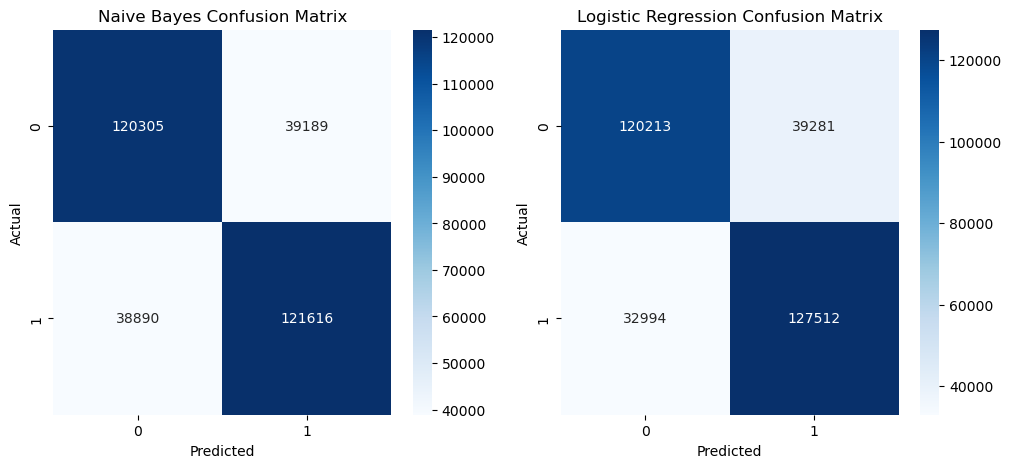

Naive Bayes Classification Report:
               precision    recall  f1-score   support

    Negative       0.76      0.75      0.75    159494
    Positive       0.76      0.76      0.76    160506

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000

Logistic Regression Classification Report:
               precision    recall  f1-score   support

    Negative       0.78      0.75      0.77    159494
    Positive       0.76      0.79      0.78    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000

Naive Bayes Cross-Validation Accuracy: 0.7496998425073204
Logistic Regression Cross-Validation Accuracy: 0.7681217300932972


In [ ]:

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

y_test_pred_nb = nb_classifier.predict(X_test)
nb_confusion_matrix = confusion_matrix(y_test, y_test_pred_nb)
nb_classification_report = classification_report(y_test, y_test_pred_nb, target_names=['Negative', 'Positive'])

y_test_pred_lr = lr_classifier.predict(X_test)
lr_confusion_matrix = confusion_matrix(y_test, y_test_pred_lr)
lr_classification_report = classification_report(y_test, y_test_pred_lr, target_names=['Negative', 'Positive'])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(nb_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Naive Bayes Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

sns.heatmap(lr_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('Logistic Regression Confusion Matrix')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

plt.show()

print("Naive Bayes Classification Report:\n", nb_classification_report)
print("Logistic Regression Classification Report:\n", lr_classification_report)

nb_cv_scores = cross_val_score(nb_classifier, X_combined, df['target'], cv=5, scoring='accuracy')
print(f"Naive Bayes Cross-Validation Accuracy: {np.mean(nb_cv_scores)}")

lr_cv_scores = cross_val_score(lr_classifier, X_combined, df['target'], cv=5, scoring='accuracy')
print(f"Logistic Regression Cross-Validation Accuracy: {np.mean(lr_cv_scores)}")

# Deployment Preparation
Save the trained model for production use. Create sample code for batch prediction and potentially real-time inference.

In [ ]:
import joblib
import re
import numpy as np
from scipy.sparse import hstack

joblib.dump(nb_classifier, 'sentiment_model_nb.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(lr_classifier, 'sentiment_model_lr.pkl')

def batch_predict(texts, model_path='sentiment_model_nb.pkl', vectorizer_path='tfidf_vectorizer.pkl'):
    """
    Loads the saved model and TF-IDF vectorizer, cleans the texts,
    transforms them into numerical features, and returns the sentiment predictions.
    """
    model = joblib.load(model_path)
    vectorizer = joblib.load(vectorizer_path)
    
    cleaned_texts = [clean_tweet(text) for text in texts]
    
    X_tfidf = vectorizer.transform(cleaned_texts)
    
    tweet_lengths = [len(text) for text in texts]
    hashtag_counts = [len([word for word in text.split() if word.startswith('#')]) for text in texts]
    mention_counts = [len([word for word in text.split() if word.startswith('@')]) for text in texts]
    
    X_additional_features = np.array([tweet_lengths, hashtag_counts, mention_counts]).T
    X_combined = hstack([X_tfidf, X_additional_features])
    
    predictions = model.predict(X_combined)
    return predictions

sample_texts = ["I love this product!", "This is the worst experience ever."]
batch_predictions = batch_predict(sample_texts)
print("Batch predictions:", batch_predictions)

Batch predictions: [4 0]
